In [1]:
import numpy as np
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

remove prev saved database:

In [2]:
dir_path = './data/humanModel/dataset_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel/dataset/', output=dir_path, ratio=(0.85, 0.15))

Copying files: 8949 files [00:00, 10339.69 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 128
IMG_SIZE = 5

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory((dir_path+'/train'),
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory((dir_path+'/val'),
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 7605 images belonging to 2 classes.
Found 1344 images belonging to 2 classes.


In [5]:
classes_count = np.bincount(train.classes)

In [6]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = classes_count[0] + classes_count[1]
weight_for_0 = (1 / classes_count[0])*(total)/2.0 
weight_for_1 = (1 / classes_count[1])*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.13
Weight for class 1: 0.89


## View some data

In [7]:
num_classes = 2

model = Sequential([
  layers.Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.MaxPooling2D(),
  layers.Conv2D(8, 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

In [8]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 5, 4)           112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 8)           296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 8)           520       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [10]:
epochs=175
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs,
  class_weight=class_weight
)

Epoch 1/175


/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


60/60 [==============================] - 2s 14ms/step - loss: 0.7824 - accuracy: 0.5206 - val_loss: 0.7549 - val_accuracy: 0.4412
Epoch 2/175
60/60 [==============================] - 1s 16ms/step - loss: 0.7370 - accuracy: 0.4961 - val_loss: 0.7228 - val_accuracy: 0.5491
Epoch 3/175
60/60 [==============================] - 1s 16ms/step - loss: 0.7169 - accuracy: 0.5290 - val_loss: 0.7114 - val_accuracy: 0.4814
Epoch 4/175
60/60 [==============================] - 1s 18ms/step - loss: 0.7069 - accuracy: 0.5120 - val_loss: 0.7025 - val_accuracy: 0.5640
Epoch 5/175
60/60 [==============================] - 1s 20ms/step - loss: 0.7018 - accuracy: 0.5320 - val_loss: 0.7016 - val_accuracy: 0.5089
Epoch 6/175
60/60 [==============================] - 1s 20ms/step - loss: 0.6976 - accuracy: 0.5233 - val_loss: 0.6885 - val_accuracy: 0.5647
Epoch 7/175
60/60 [==============================] - 1s 20ms/step - loss: 0.6956 - accuracy: 0.5314 - val_loss: 0.6876 - val_accuracy: 0.5744
Epoch 8/175
60/60 

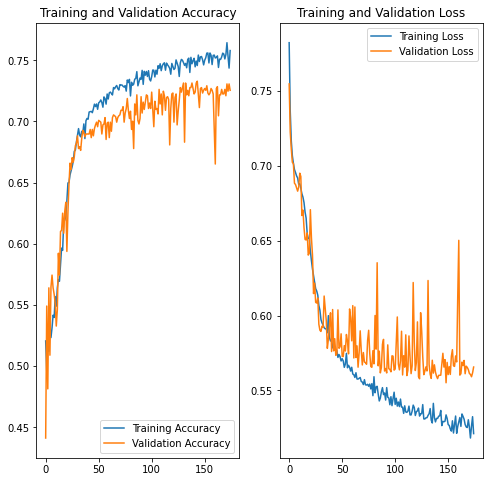

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

11/11 [==============================] - 0s 12ms/step - loss: 0.5656 - accuracy: 0.7254
Test accuracy : 0.7254464030265808


In [13]:
y_pred = model.predict(test).argmax(axis=-1)
y_true = test.classes

m = tf.keras.metrics.Precision()
m.update_state(y_pred, y_true)
print("Precision: " , m.result().numpy())

m = tf.keras.metrics.Recall()
m.update_state(y_pred, y_true)
print("Recall: " , m.result().numpy())

Precision:  0.60186416
Recall:  0.565


In [14]:
tf.math.confusion_matrix(y_pred, y_true)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[245, 299],
       [348, 452]], dtype=int32)>

In [15]:
# Save the weights model.
model.save('./data/humanModel/model_v2.h5')

In [16]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [17]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

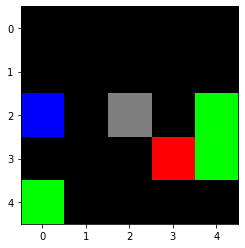

This image most likely belongs to closest_bush with a 86.47 percent confidence.
True class is closest_bush.


In [18]:
import glob

classes = ['closest_bush', 'follow_stag']
random_class = random.choice(classes)

path = "./data/humanModel/dataset_split/val/"+random_class
all_images_path = glob.glob(path + "/*.png")
random_path = random.choice(all_images_path)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(random_path)
imgplot = plt.imshow(img)
plt.show()

img = keras.preprocessing.image.load_img(
    random_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255

predictions = model.predict(img_array)[0]


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(predictions)], 100 * np.max(predictions))
)
print("True class is {}.".format(random_class))